# Dashboard de Vendas

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

In [ ]:
# Conexão com PostgreSQL
usuario = 'postgres'
senha = 'senha'
host = 'db-devops'  
porta = '5432'
banco = 'dashboard'

engine = create_engine(f'postgresql+psycopg2://{usuario}:{senha}@{host}:{porta}/{banco}')

In [23]:
# Leitura de volta das tabelas
df_lojas = pd.read_sql('SELECT * FROM lojas', engine)
df_produtos = pd.read_sql('SELECT * FROM produtos', engine)
df_clima = pd.read_sql('SELECT * FROM clima', engine)
df_chocolate = pd.read_sql('SELECT * FROM chocolate', engine)
df_vendas = pd.read_sql('SELECT * FROM vendas', engine)

print(df_lojas.head())
print(df_produtos.head())
print(df_clima.head())
print(df_chocolate.head())
print(df_vendas.head())

  Cod. Produto                     Produto            Categoria  \
0       BA0001      Barra ao Leite Suprema  Barras de Chocolate   
1       BA0002  Barra com Frutas Vermelhas  Barras de Chocolate   
2       BA0003         Barra Dark Fantasia  Barras de Chocolate   
3       BA0004   Barra de Caramelo Salgado  Barras de Chocolate   
4       BO0001  Bombom de Caramelo Salgado              Bombons   

   Valor Unitario  
0        R$ 21.71  
1        R$ 11.62  
2       R$ 33.76   
3       R$ 41.78   
4       R$ 14.74   


# Total de Vendas por Loja

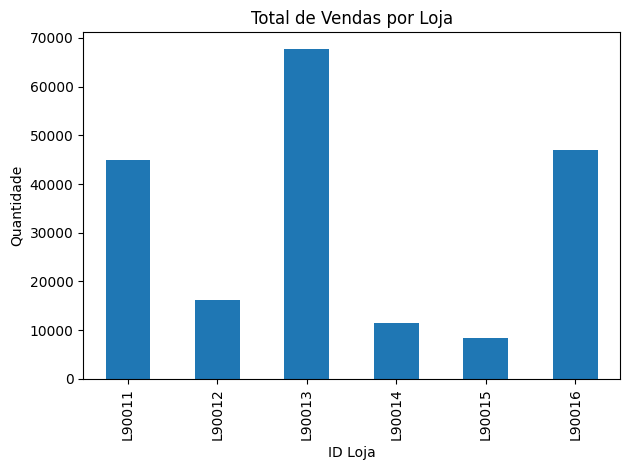

In [24]:
# Agrupamento e visualização
vendas_por_loja = df_vendas.groupby('ID Loja')['Quantidade'].sum()

vendas_por_loja.plot(kind='bar', title='Total de Vendas por Loja', ylabel='Quantidade')
plt.tight_layout()
plt.show()

# Tipos de chocolate × Custo estimado por kg

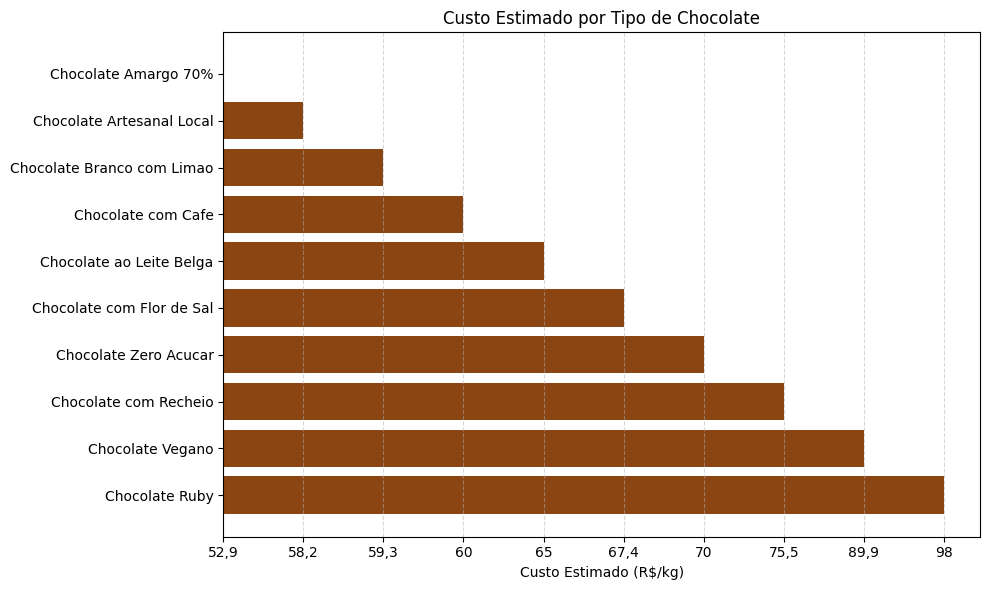

In [26]:
df_chocolate = pd.DataFrame(df_chocolate)

# Ordenar por custo crescente
df_chocolate = df_chocolate.sort_values(by='Custo Estimado (R$/kg)', ascending=True)

# Plotar gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(df_chocolate['Tipo de Chocolate'], df_chocolate['Custo Estimado (R$/kg)'], color='saddlebrown')
plt.xlabel('Custo Estimado (R$/kg)')
plt.title('Custo Estimado por Tipo de Chocolate')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()  # Mais caro no topo
plt.show()

# Custo Estimado por KG x Categoria

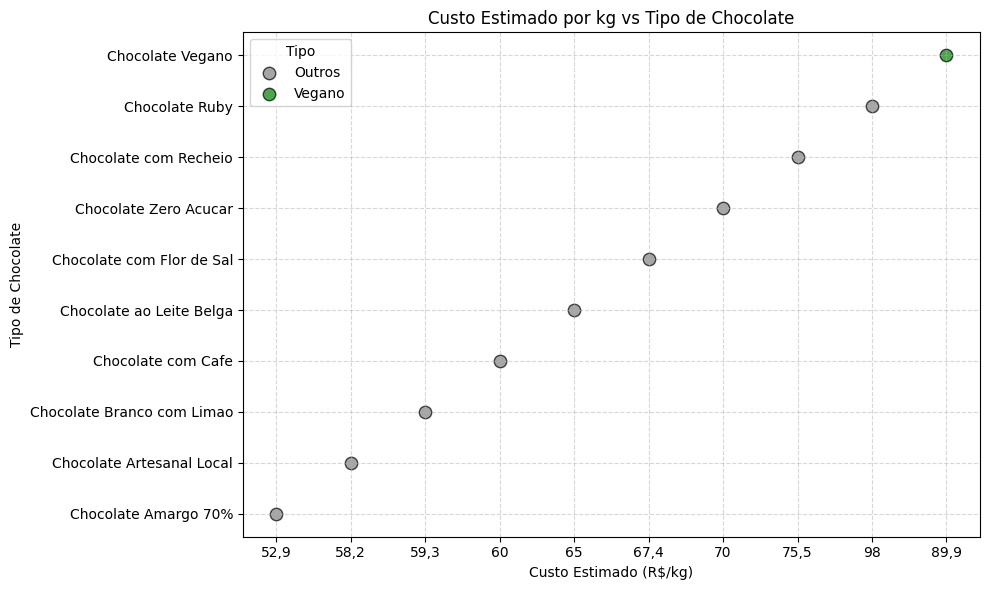

In [27]:
# Criar uma coluna de destaque com base no 'Tipo de Chocolate'
df_chocolate['Destaque'] = df_chocolate['Tipo de Chocolate'].apply(
    lambda x: 'Vegano' if 'vegano' in x.lower() else ('Gourmet' if 'gourmet' in x.lower() else 'Outros')
)

# Cores para cada grupo
cores = {'Vegano': 'green', 'Gourmet': 'gold', 'Outros': 'gray'}

# Plotando o gráfico de dispersão
plt.figure(figsize=(10, 6))

for destaque, grupo in df_chocolate.groupby('Destaque'):
    plt.scatter(grupo['Custo Estimado (R$/kg)'], grupo['Tipo de Chocolate'], 
                label=destaque, color=cores[destaque], s=80, alpha=0.7, edgecolors='k')

plt.xlabel('Custo Estimado (R$/kg)')
plt.ylabel('Tipo de Chocolate')
plt.title('Custo Estimado por kg vs Tipo de Chocolate')
plt.legend(title='Tipo')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Total de vendas por loja X Categoria

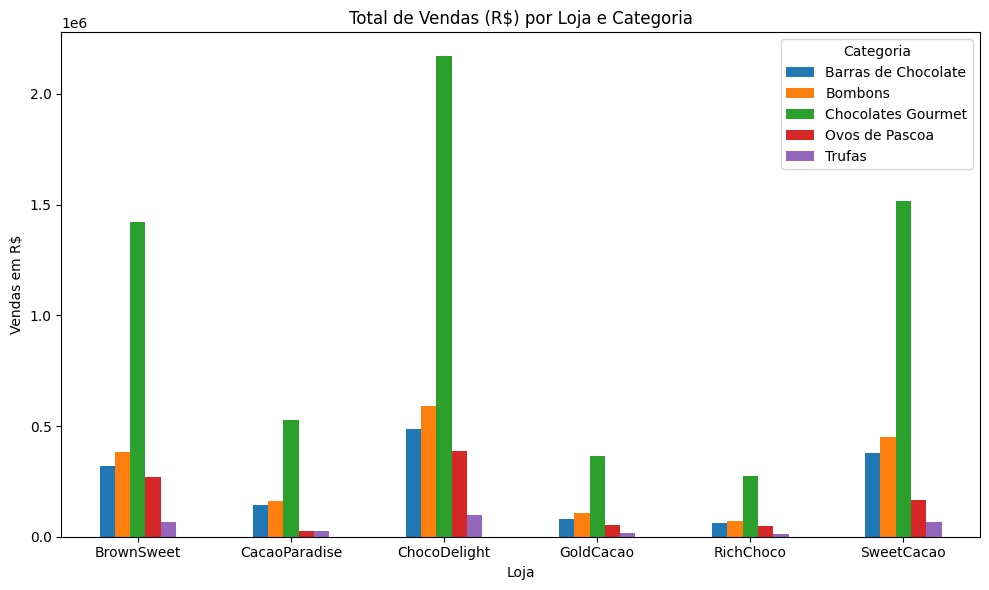

In [28]:
# Juntando os dados de Vendas, Produtos, e Lojas
df = df_vendas.merge(df_lojas, on='ID Loja')

# Juntar com lojas (para pegar nome da loja)
df = df.merge(df_produtos, on='Cod. Produto')

# Mudando o tipo do valor total para Float
df['Valor Total'] = df['Valor Total'].replace(',', '.', regex=True).astype(float)

# Agrupando por loja 
tabela = df.groupby(['Loja', 'Categoria'])['Valor Total'].sum().reset_index()

# Pivotar para gráfico de barras agrupadas
pivotada = tabela.pivot(index='Loja', columns='Categoria', values='Valor Total').fillna(0)

# Plotar
pivotada.plot(kind='bar', figsize=(10, 6))
plt.title('Total de Vendas (R$) por Loja e Categoria')
plt.ylabel('Vendas em R$')
plt.xlabel('Loja')
plt.xticks(rotation=0)
plt.legend(title='Categoria')
plt.tight_layout()
plt.show()

# Relação entre loja e produto mais vendido

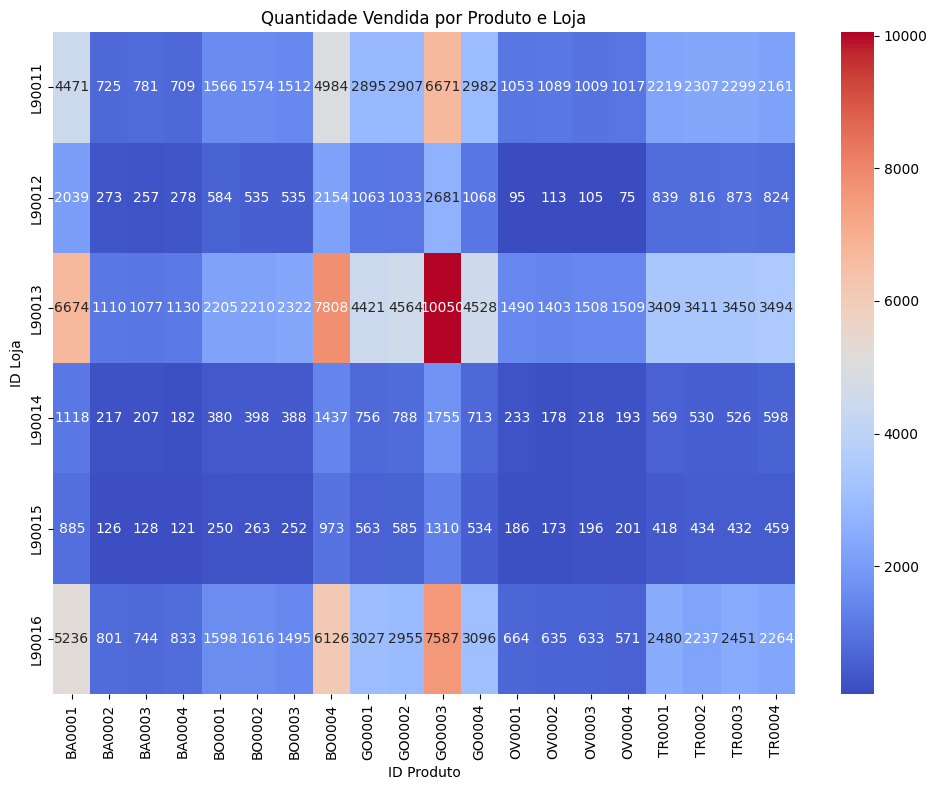

In [44]:
tabela = df_vendas.pivot_table(index='ID Loja', columns='Cod. Produto', values='Quantidade', aggfunc='sum', fill_value=0)

# Criar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(tabela, annot=True, cmap='coolwarm', fmt='d')
plt.title('Quantidade Vendida por Produto e Loja')
plt.xlabel('ID Produto')
plt.ylabel('ID Loja')
plt.tight_layout()
plt.show()




# Quantidade de cidades por clima predominante

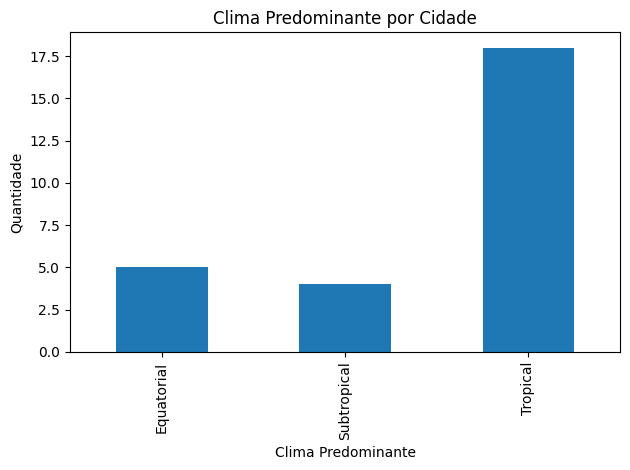

In [47]:
cidades_clima = df_clima.groupby('Clima Predominante')['Cidade'].count()

cidades_clima.plot(kind='bar',  title='Clima Predominante por Cidade', ylabel='Quantidade')
plt.tight_layout()
plt.show()